In [80]:
import shap
import numpy as np
import pandas as pd
import sklearn.svm as svm
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import genfromtxt
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

In [81]:
gesture = ["Down", "Up", "Left", "Right"]
path = "HeadData/"
gyro = "/gyro/"
features = 6
trials = 40
x = [[0] * features for i in range(trials * len(gesture))]
y = [0] * trials * len(gesture)

In [82]:
def min_max_feature_order(s1, s2):
    if s1 > s2:
        return 1
    else:
        return 5

# Feature Extraction and Labelling (Slide 70 Demo-1, Slide 72 Demo-2)
Below shows the features that are declared, and their extraction process for all of the 
data

In [83]:
for i in range(0, len(gesture), 1): # i is the nominal value of the class Gesture which takes values 0,1,2,3 for Down, Up, Left, Right
    for k in range(0, trials, 1):
        path_data = path + gesture[i] + gyro + "trial" + str(k + 1) + ".csv"
        data = genfromtxt(path_data, delimiter=",")
        # Features
        x[k + i * trials][0] = min_max_feature_order(np.argmax(data[:, 1]), np.argmin(data[:, 1]))
        x[k + i * trials][1] = min_max_feature_order(np.argmax(data[:, 3]), np.argmin(data[:, 3]))
        x[k + i * trials][2] = min_max_feature_order(np.argmax(data[:, 2]), np.argmin(data[:, 2]))
        x[k + i * trials][3] = min(data[:, 1])  # down up gestures the x dimension changes the most
        x[k + i * trials][4] = min(data[:, 3])  # right left gestures the z dimension changes the most
        x[k + i * trials][5] = min(data[:, 2])
        # x[k+i*trials][4]=max(data[:,1]) # down up gestures the x dimension changes the most
        # x[k+i*trials][5]=max(data[:,3]) # right left gestures the z dimension changes the most
        # x[k+i*trials][6]=data[:,1].mean() # mean for x dimension
        # x[k+i*trials][7]=data[:,3].mean() # mean for z dimension
        # x[k+i*trials][8]=data[:,1].std() # std for x dimension
        # x[k+i*trials][9]=data[:,3].std() # std for z dimension
        # target variables
        y[[k + i * trials][0]] = i

In [84]:
# Split dataset into training set and test set
# 75% training and 25% test
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=0)  

In [85]:
# Create a svm Classifier
clf = svm.SVC(kernel="linear")  # Linear Kernel

# Train the model using the training sets
clf.fit(X_train, y_train)

# Predict the response for test dataset
y_pred = clf.predict(X_test)

In [86]:
# Micro-averaging can be more influenced by the performance of the larger classes, whereas macro-averaging treats all classes equally.
# Micro-averaging may be more appropriate when you are dealing with imbalanced datasets or when you are more interested in the overall performance of the model. 
# Macro-averaging can be useful when you want to evaluate the model's performance on smaller classes.
def get_metrics(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='micro')
    recall = recall_score(y_test, y_pred, average='micro')
    f1 = f1_score(y_test, y_pred, average='micro')
    return cm, accuracy, precision, recall, f1

Accuracy: 0.85
Precision: 0.85
Recall: 0.85
F1 Score: 0.85


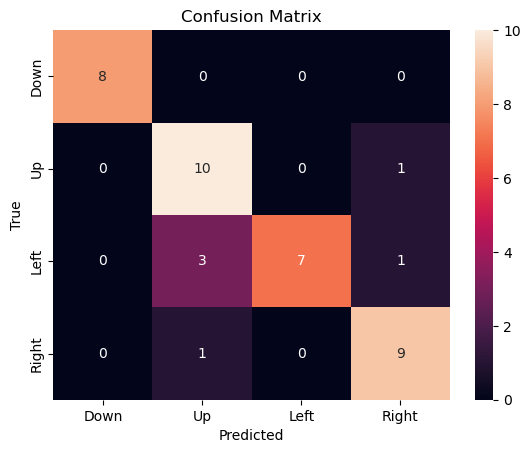

In [87]:
cm, accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
# Plot the confusion matrix
cm_df = pd.DataFrame(cm, index=gesture, columns=gesture)
sns.heatmap(cm_df, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

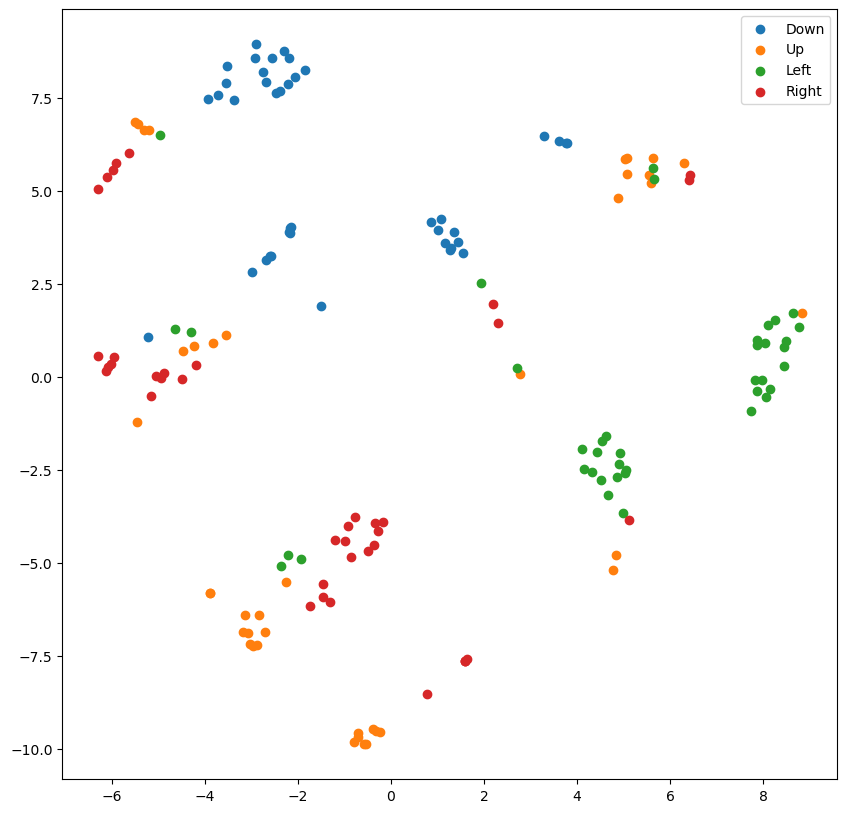

In [88]:
tsne = TSNE(n_components=2)
X_normalized = normalize(np.array(x), axis=0, norm="max")
X_embedded = tsne.fit_transform(X_normalized)
plt.figure(figsize=(10, 10))
plt.scatter(X_embedded[np.array(y) == 0, 0], X_embedded[np.array(y) == 0, 1], label=gesture[0])
plt.scatter(X_embedded[np.array(y) == 1, 0], X_embedded[np.array(y) == 1, 1], label=gesture[1])
plt.scatter(X_embedded[np.array(y) == 2, 0], X_embedded[np.array(y) == 2, 1], label=gesture[2])
plt.scatter(X_embedded[np.array(y) == 3, 0], X_embedded[np.array(y) == 3, 1], label=gesture[3])
plt.legend()
plt.show()

Accuracy: 0.875
Precision: 0.875
Recall: 0.875
F1 Score: 0.875


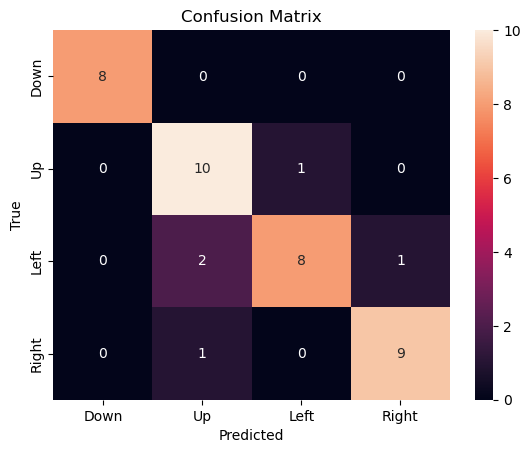

In [89]:
dtree = DecisionTreeClassifier()
dtree.fit(X_train, y_train)
# test the model
predictions = dtree.predict(X_test)
# Get all the metrics
cm, accuracy, precision, recall, f1 = get_metrics(y_test, predictions)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
# Plot the confusion matrix
cm_df = pd.DataFrame(cm, index=gesture, columns=gesture)
sns.heatmap(cm_df, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

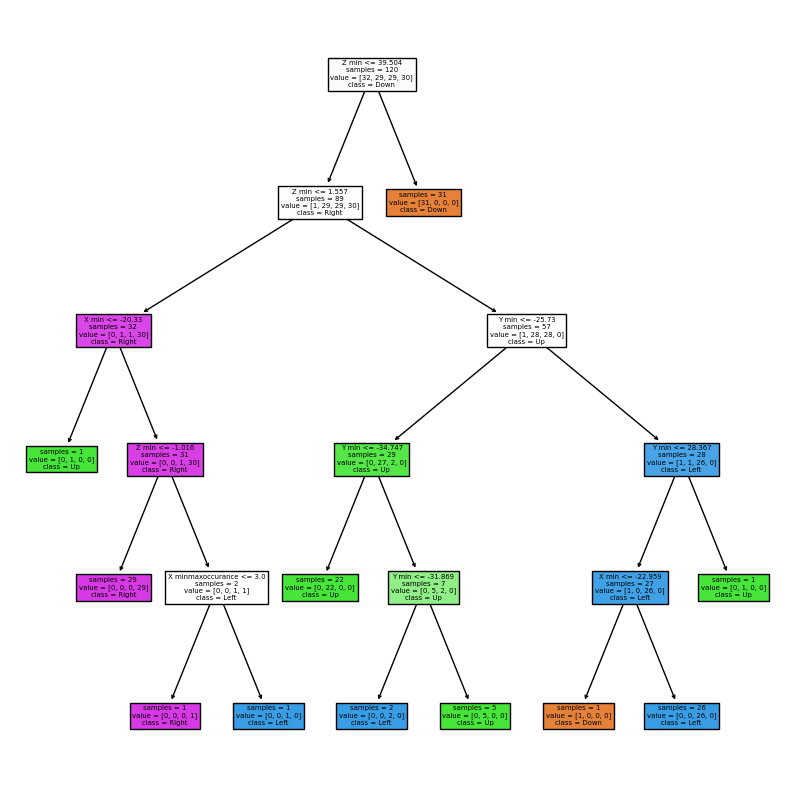

In [90]:
plt.figure(figsize=(10, 10))
feature_names = ["X minmaxoccurance", "Z minmaxoccurance", "Y minmaxoccurance", "X min", "Z min", "Y min"]
target_names = gesture
tree.plot_tree(dtree, filled=True, impurity=False, feature_names=feature_names, class_names=target_names)
plt.show()

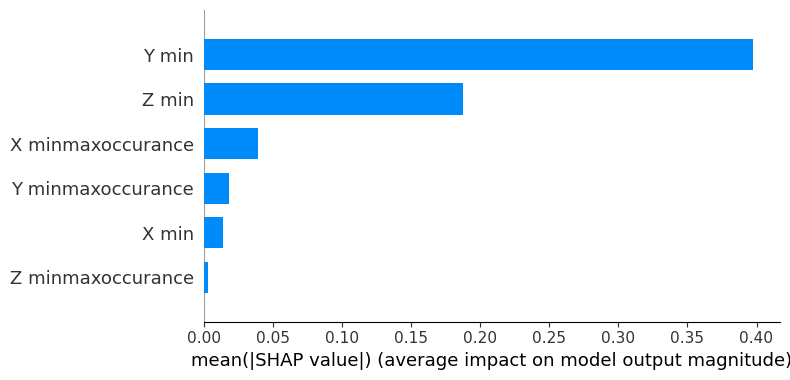

In [91]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=0)

clf = svm.SVC(kernel="linear")
clf.fit(np.array(X_train), np.array(y_train))

explainer = shap.Explainer(clf, np.array(X_train))
shap_values_individual = explainer.shap_values(np.array(X_test))
shap_values = np.mean(shap_values_individual, axis=1)
feature_names = ["X minmaxoccurance", "Z minmaxoccurance", "Y minmaxoccurance", "X min", "Z min", "Y min"]
target_names = ["Down", "Up", "Left", "Right"]
shap.summary_plot(shap_values, plot_type="bar", class_names=target_names, feature_names=feature_names)

Accuracy: 0.8
Precision: 0.8
Recall: 0.8
F1 Score: 0.8000000000000002


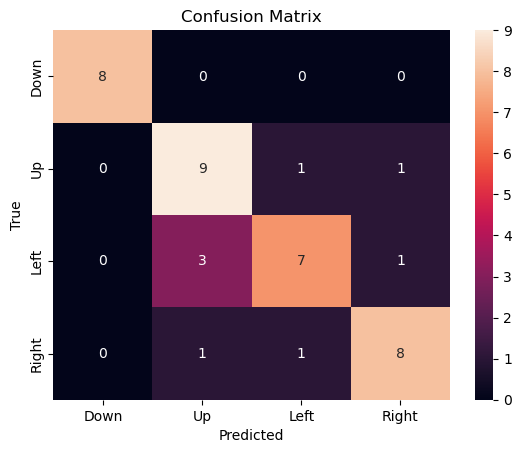

In [92]:
numpy_x = np.array(x)
numpy_y = np.array(y)
X_train, X_test, y_train, y_test = train_test_split(numpy_x, numpy_y, test_size=0.25, random_state=0)
X_train = X_train[:, [0, 4, 5]]
X_test = X_test[:, [0, 4, 5]]
clf = svm.SVC(kernel="linear")
clf.fit(np.array(X_train), np.array(y_train))
y_pred = clf.predict(X_test)
cm, accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
# Plot the confusion matrix
cm_df = pd.DataFrame(cm, index=gesture, columns=gesture)
sns.heatmap(cm_df, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


Accuracy: 0.45
Precision: 0.45
Recall: 0.45
F1 Score: 0.45


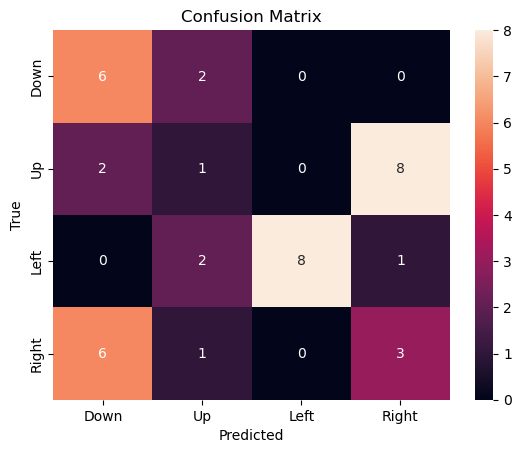

In [93]:
numpy_x = np.array(x)
numpy_y = np.array(y)
X_train, X_test, y_train, y_test = train_test_split(numpy_x, numpy_y, test_size=0.25, random_state=0)
X_train = X_train[:, [1, 2, 3]]
X_test = X_test[:, [1, 2, 3]]
clf = svm.SVC(kernel="linear")
clf.fit(np.array(X_train), np.array(y_train))
y_pred = clf.predict(X_test)
cm, accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
# Plot the confusion matrix
cm_df = pd.DataFrame(cm, index=gesture, columns=gesture)
sns.heatmap(cm_df, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


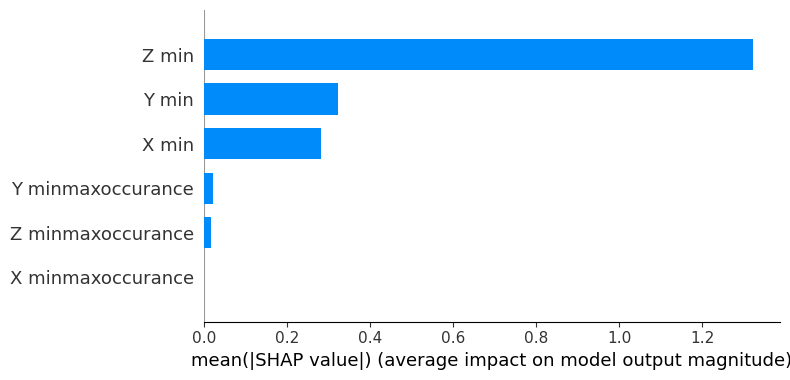

In [94]:
# gesture = ['Down', 'Up', 'Left', 'Right']
gesture = ["Left", "Right"]
path = "HeadData/"
gyro = "/gyro/"
features = 6
trials = 40
x = [[0] * features for i in range(trials * len(gesture))]
y = [0] * trials * len(gesture)
for i in range(0, len(gesture), 1):
    for k in range(0, trials, 1):
        path_data = path + gesture[i] + gyro + "trial" + str(k + 1) + ".csv"
        data = genfromtxt(path_data, delimiter=",")
        # Features
        x[k + i * trials][0] = min_max_feature_order(np.argmax(data[:, 1]), np.argmin(data[:, 1]))
        x[k + i * trials][1] = min_max_feature_order(np.argmax(data[:, 3]), np.argmin(data[:, 3]))
        x[k + i * trials][2] = min_max_feature_order(np.argmax(data[:, 2]), np.argmin(data[:, 2]))
        x[k + i * trials][3] = min(data[:, 1])  # down up gestures the x dimension changes the most
        x[k + i * trials][4] = min(data[:, 3])  # right left gestures the z dimension changes the most
        x[k + i * trials][5] = min(data[:, 2])
        # x[k+i*trials][4]=max(data[:,1]) # down up gestures the x dimension changes the most
        # x[k+i*trials][5]=max(data[:,3]) # right left gestures the z dimension changes the most
        # x[k+i*trials][6]=data[:,1].mean() # mean for x dimension
        # x[k+i*trials][7]=data[:,3].mean() # mean for z dimension
        # x[k+i*trials][8]=data[:,1].std() # std for x dimension
        # x[k+i*trials][9]=data[:,3].std() # std for z dimension
        # target variables
        y[[k + i * trials][0]] = i
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=0)

clf = svm.SVC(kernel="linear")
clf.fit(np.array(X_train), np.array(y_train))

explainer = shap.Explainer(clf, np.array(X_train))
shap_values_individual = explainer.shap_values(np.array(X_test))
shap_values = sum(shap_values_individual) / len(shap_values_individual)
feature_names = ["X minmaxoccurance", "Z minmaxoccurance", "Y minmaxoccurance", "X min", "Z min", "Y min"]

shap.summary_plot(shap_values.reshape(1, -1), plot_type="bar", feature_names=feature_names)